In [8]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_excel("initial_data/nipt_data.xlsx")
print(df.head())

   序号  孕妇代码  年龄     身高    体重                 末次月经 IVF妊娠      检测日期  检测抽血次数  \
0   1  A001  31  160.0  72.0  2023-02-01 00:00:00  自然受孕  20230429       1   
1   2  A001  31  160.0  73.0  2023-02-01 00:00:00  自然受孕  20230531       2   
2   3  A001  31  160.0  73.0  2023-02-01 00:00:00  自然受孕  20230625       3   
3   4  A001  31  160.0  74.0  2023-02-01 00:00:00  自然受孕  20230716       4   
4   5  A002  32  149.0  74.0  2023-11-09 00:00:00  自然受孕  20240219       1   

    检测孕周  ...    Y染色体浓度    X染色体浓度  13号染色体的GC含量  18号染色体的GC含量  21号染色体的GC含量  \
0  11w+6  ...  0.025936  0.038061     0.377069     0.389803     0.399399   
1  15w+6  ...  0.034887  0.059572     0.371542     0.384771     0.391706   
2  20w+1  ...  0.066171  0.075995     0.377449     0.390582     0.399480   
3  22w+6  ...  0.061192  0.052305     0.375613     0.389251     0.397212   
4  13w+6  ...  0.059230  0.059708     0.380260     0.393618     0.404868   

   被过滤掉读段数的比例  染色体的非整倍体  怀孕次数  生产次数  胎儿是否健康  
0    0.027484       NaN     1     

In [9]:
BMI_info_log=1/df['孕妇BMI']
BMI_info=df['孕妇BMI']
Y_info=df['Y染色体浓度']

def convert_ga_to_decimal(ga_str):
    """将“Xw+Y”格式转换为小数周（如11w+6 = 11 + 6/7 ≈ 11.86周）"""
    if pd.isna(ga_str):
        return np.nan
    if 'w+' in str(ga_str):
        w_part, d_part = str(ga_str).split('w+')
    else:
        return np.nan
    try:
        return int(w_part) + int(d_part) / 7
    except (ValueError, IndexError):
        return np.nan
    

df['小数孕周'] = df['检测孕周'].apply(convert_ga_to_decimal)
df = df[(df['小数孕周'] >= 10) & (df['小数孕周'] <= 25)]

gestational_weeks_info=df['小数孕周']

In [10]:
height_info = df['身高']
weight_info = df['体重']
BMI_calculate = weight_info / (height_info / 100) ** 2
error=(BMI_calculate - BMI_info)/BMI_calculate

threshold = 0.1
mask = error.abs() > threshold

print(df[mask])

Empty DataFrame
Columns: [序号, 孕妇代码, 年龄, 身高, 体重, 末次月经, IVF妊娠, 检测日期, 检测抽血次数, 检测孕周, 孕妇BMI, 原始读段数, 在参考基因组上比对的比例, 重复读段的比例, 唯一比对的读段数  , GC含量, 13号染色体的Z值, 18号染色体的Z值, 21号染色体的Z值, X染色体的Z值, Y染色体的Z值, Y染色体浓度, X染色体浓度, 13号染色体的GC含量, 18号染色体的GC含量, 21号染色体的GC含量, 被过滤掉读段数的比例, 染色体的非整倍体, 怀孕次数, 生产次数, 胎儿是否健康, 小数孕周]
Index: []

[0 rows x 32 columns]


C:\Users\xia\AppData\Local\Temp\ipykernel_30100\2406130129.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[mask])


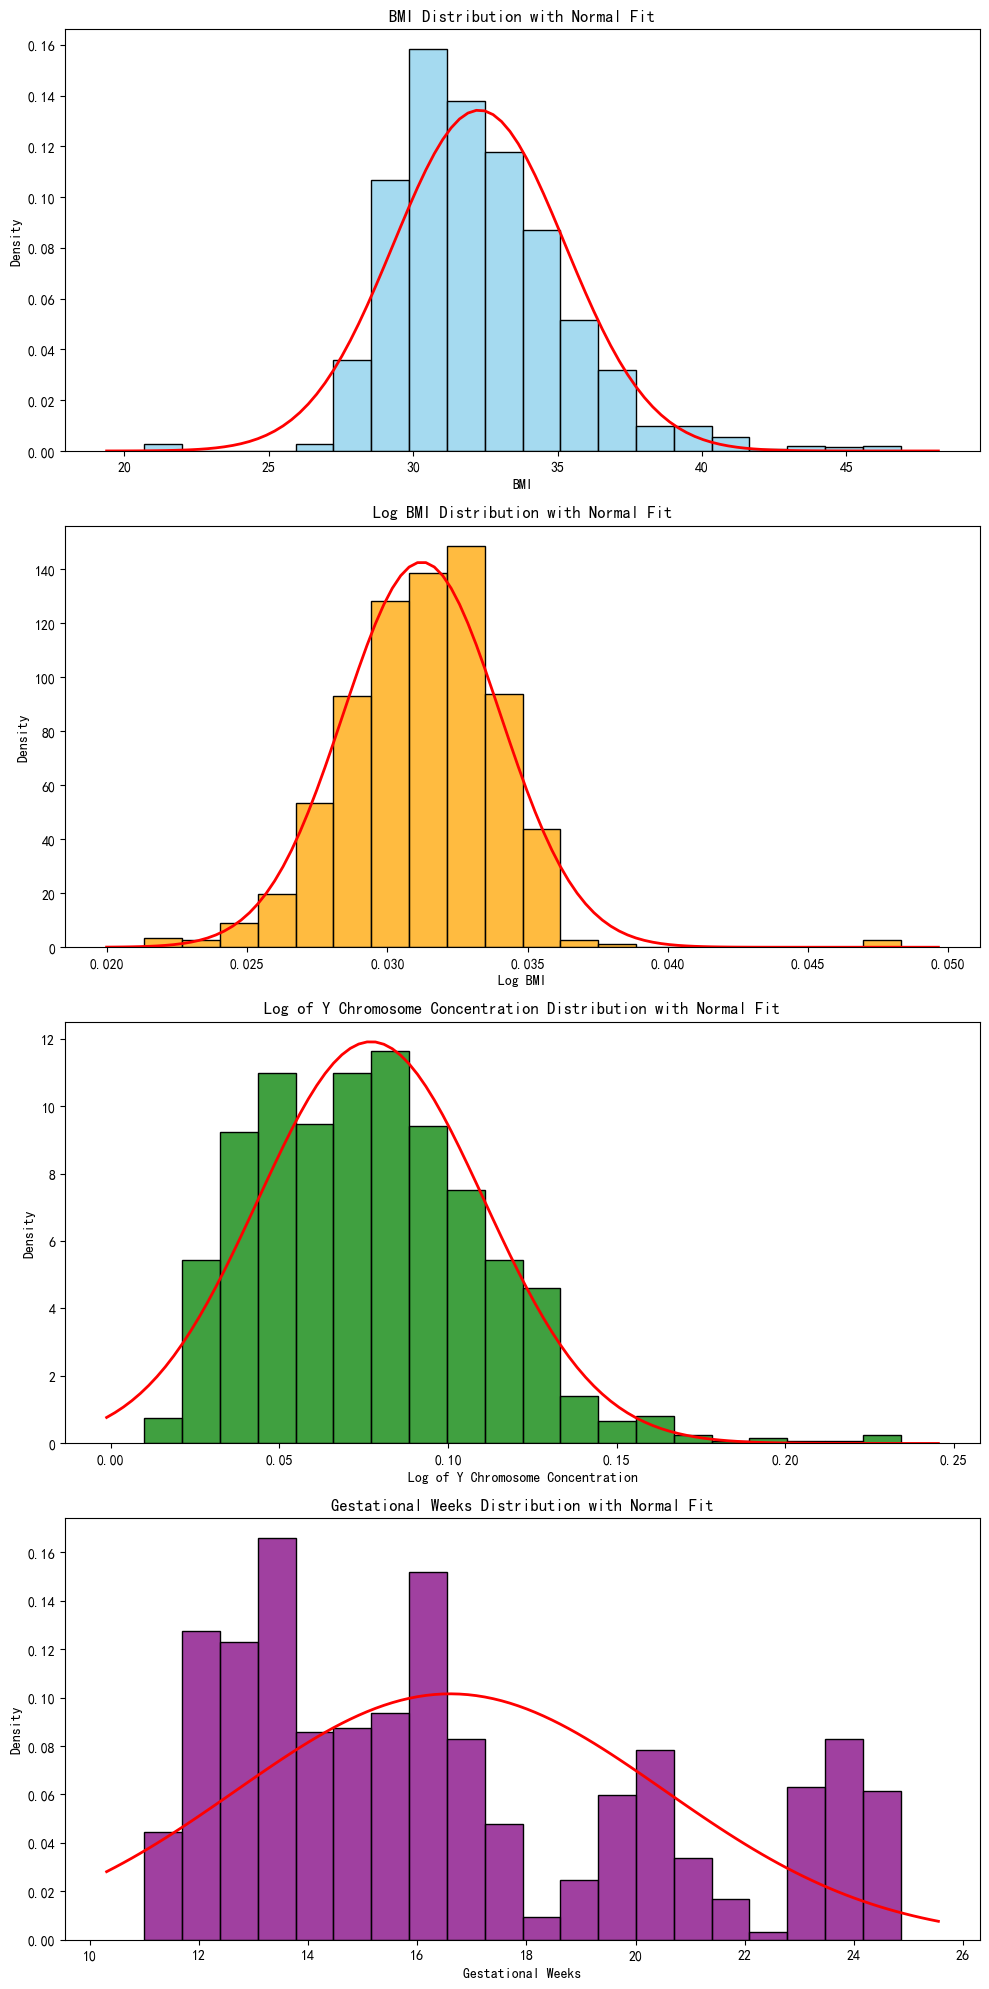

In [11]:
# 设置子图的布局
fig, axes = plt.subplots(4, 1, figsize=(10, 20))

sns.histplot(BMI_info, bins=20, kde=False, color='skyblue', stat='density', ax=axes[0])
mu_bmi, std_bmi = stats.norm.fit(BMI_info)
xmin_bmi, xmax_bmi = axes[0].get_xlim()
x_bmi = np.linspace(xmin_bmi, xmax_bmi, 100)
p_bmi = stats.norm.pdf(x_bmi, mu_bmi, std_bmi)
axes[0].plot(x_bmi, p_bmi, 'r', linewidth=2)
axes[0].set_title('BMI Distribution with Normal Fit')
axes[0].set_xlabel('BMI')
axes[0].set_ylabel('Density')
# 绘制BMI_log的直方图及正态分布拟合
sns.histplot(BMI_info_log, bins=20, kde=False, color='orange', stat='density', ax=axes[1])
mu_bmi_log, std_bmi_log = stats.norm.fit(BMI_info_log)
xmin_bmi_log, xmax_bmi_log = axes[1].get_xlim()
x_bmi_log = np.linspace(xmin_bmi_log, xmax_bmi_log, 100)
p_bmi_log = stats.norm.pdf(x_bmi_log, mu_bmi_log, std_bmi_log)
axes[1].plot(x_bmi_log, p_bmi_log, 'r', linewidth=2)
axes[1].set_title('Log BMI Distribution with Normal Fit')
axes[1].set_xlabel('Log BMI')
axes[1].set_ylabel('Density')
# 绘制Y染色体浓度对数的直方图及正态分布拟合
sns.histplot(Y_info, bins=20, kde=False, color='green', stat='density', ax=axes[2])
mu_y, std_y = stats.norm.fit(Y_info)
xmin_y, xmax_y = axes[2].get_xlim()
x_y = np.linspace(xmin_y, xmax_y, 100)
p_y = stats.norm.pdf(x_y, mu_y, std_y)
axes[2].plot(x_y, p_y, 'r', linewidth=2)
axes[2].set_title('Log of Y Chromosome Concentration Distribution with Normal Fit')
axes[2].set_xlabel('Log of Y Chromosome Concentration')
axes[2].set_ylabel('Density')
# 绘制检测孕周的直方图及正态分布拟合
sns.histplot(gestational_weeks_info, bins=20, kde=False, color='purple', stat='density', ax=axes[3])
mu_gw, std_gw = stats.norm.fit(gestational_weeks_info)
xmin_gw, xmax_gw = axes[3].get_xlim()
x_gw = np.linspace(xmin_gw, xmax_gw, 100)
p_gw = stats.norm.pdf(x_gw, mu_gw, std_gw)
axes[3].plot(x_gw, p_gw, 'r', linewidth=2)
axes[3].set_title('Gestational Weeks Distribution with Normal Fit')
axes[3].set_xlabel('Gestational Weeks')
axes[3].set_ylabel('Density')
# 调整子图之间的间距
plt.tight_layout()
plt.show()

C:\Users\xia\AppData\Local\Temp\ipykernel_30100\3814798988.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log_BMI'] = BMI_info_log


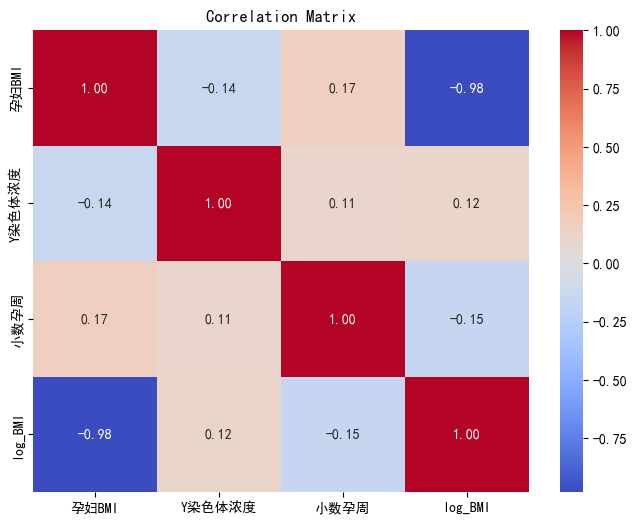

In [12]:
data = df[['孕妇BMI', 'Y染色体浓度', '小数孕周']]
# 确保数据是数值类型
data['log_BMI'] = BMI_info_log
data = data.apply(pd.to_numeric, errors='coerce')
# 计算相关性矩阵
corr_matrix = data.corr()
# 绘制相关性矩阵的热图
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

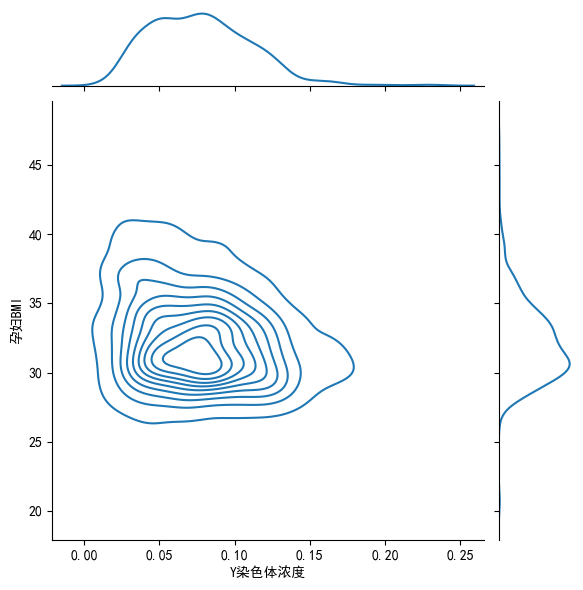

In [13]:
import seaborn as sns
sns.jointplot(x=Y_info, y=BMI_info, kind='kde')
plt.show()

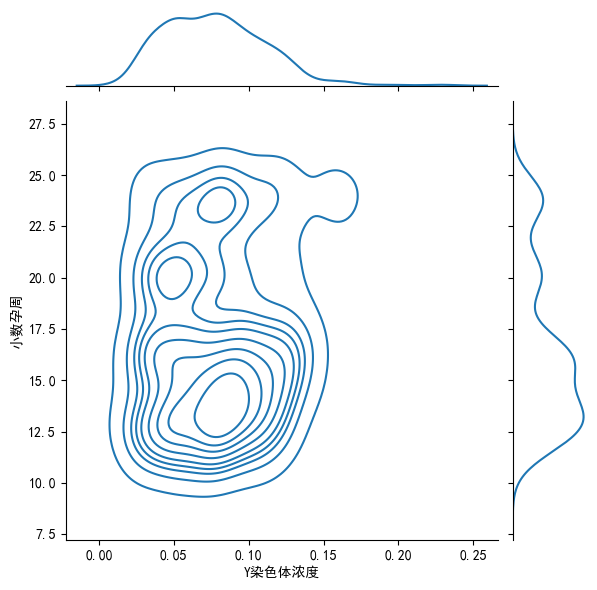

In [14]:
import seaborn as sns
sns.jointplot(x=Y_info, y=gestational_weeks_info, kind='kde')
plt.show()

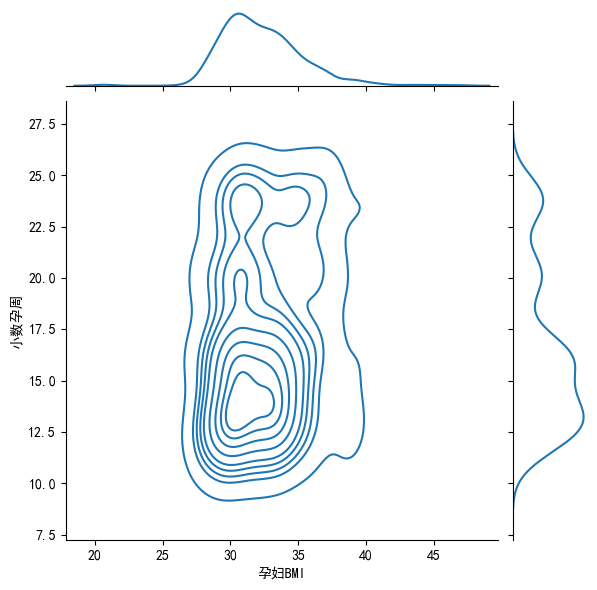

In [15]:
import seaborn as sns
sns.jointplot(x=BMI_info, y=gestational_weeks_info, kind='kde')
plt.show()

In [37]:
filtered = df.drop_duplicates(subset='孕妇代码', keep='first')
print(filtered)

        序号  孕妇代码  年龄     身高     体重                 末次月经 IVF妊娠  \
0        1  A001  31  160.0  72.00  2023-02-01 00:00:00  自然受孕   
4        5  A002  32  149.0  74.00  2023-11-09 00:00:00  自然受孕   
12      13  A003  35  160.0  79.72  2023-02-20 00:00:00  自然受孕   
16      17  A004  26  158.0  71.50  2023-06-11 00:00:00  自然受孕   
19      20  A005  30  150.0  67.40  2023-04-15 00:00:00  自然受孕   
...    ...   ...  ..    ...    ...                  ...   ...   
1062  1063  A263  30  157.0  72.34           2022-12-28  自然受孕   
1066  1067  A264  30  171.0  94.95           2022-12-27  自然受孕   
1070  1071  A265  32  168.0  95.17           2022-12-28  自然受孕   
1074  1075  A266  30  159.0  81.24           2022-12-29  自然受孕   
1078  1079  A267  28  155.0  73.76           2023-02-25  自然受孕   

                     检测日期  检测抽血次数   检测孕周  ...    X染色体浓度  13号染色体的GC含量  \
0                20230429       1  11w+6  ...  0.038061     0.377069   
4                20240219       1  13w+6  ...  0.059708     0.380260   
12 

c:\Users\xia\anaconda3\envs\MCM\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\xia\AppData\Local\Temp\ipykernel_30100\851597833.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Y染色体浓度'] = n_Y_info


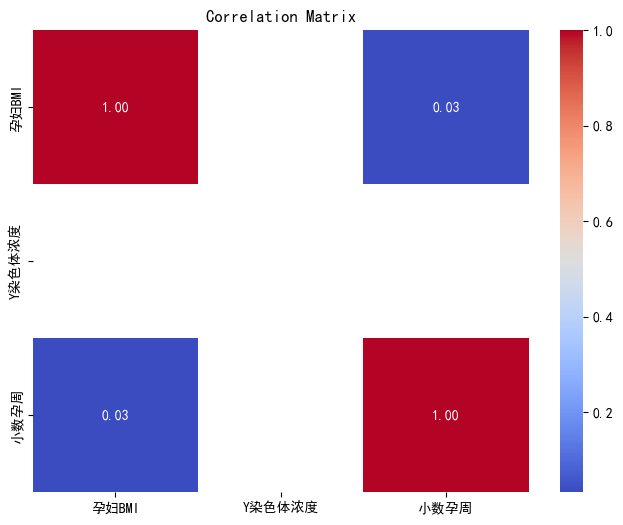

In [ ]:
data = df[['孕妇BMI', 'Y染色体浓度', '小数孕周']]
# 确保数据是数值类型

data = data.apply(pd.to_numeric, errors='coerce')
# 计算相关性矩阵
corr_matrix = data.corr()
# 绘制相关性矩阵的热图
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

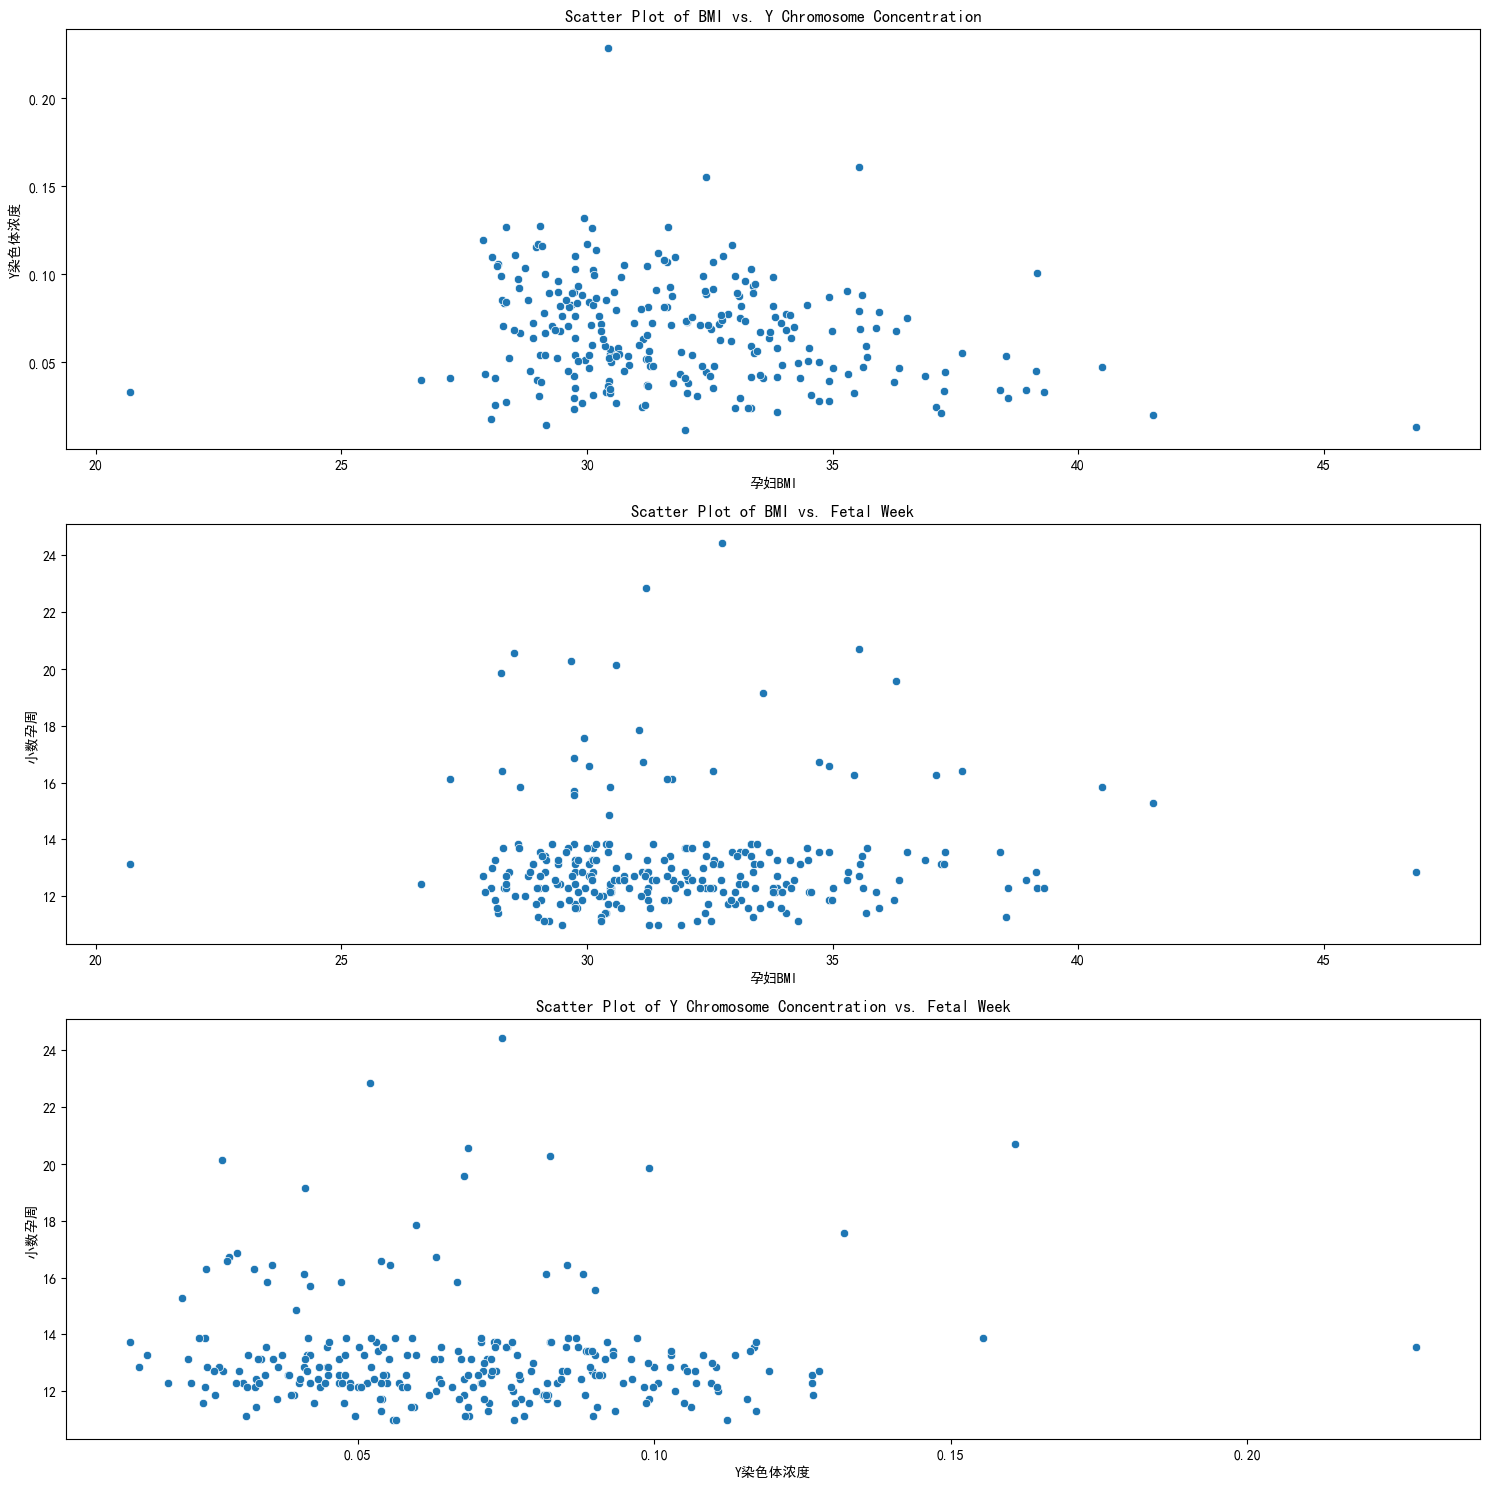

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
# 设置画布大小
plt.figure(figsize=(15, 15))
# 绘制孕妇BMI vs Y染色体浓度
plt.subplot(3, 1, 1)
sns.scatterplot(x='孕妇BMI', y='Y染色体浓度', data=data)
plt.title('Scatter Plot of BMI vs. Y Chromosome Concentration')
plt.xlabel('孕妇BMI')
plt.ylabel('Y染色体浓度')
# 绘制孕妇BMI vs 小数孕周
plt.subplot(3, 1, 2)
sns.scatterplot(x='孕妇BMI', y='小数孕周', data=data)
plt.title('Scatter Plot of BMI vs. Fetal Week')
plt.xlabel('孕妇BMI')
plt.ylabel('小数孕周')
# 绘制Y染色体浓度 vs 小数孕周
plt.subplot(3, 1, 3)
sns.scatterplot(x='Y染色体浓度', y='小数孕周', data=data)
plt.title('Scatter Plot of Y Chromosome Concentration vs. Fetal Week')
plt.xlabel('Y染色体浓度')
plt.ylabel('小数孕周')
# 调整布局以避免重叠
plt.tight_layout()
# 显示图形
plt.show()